In [19]:
import torch
from pathlib import Path
import os
import hydra
import numpy as np
import matplotlib.pyplot as plt
import pickle

os.chdir('/workspace')
import src

In [20]:
with hydra.initialize(config_path="../conf", version_base='1.1'):
    cfg = hydra.compose(
        config_name='config',
        overrides=[
            "model=KAN1h",
            "model.model.width.1=1",
            "model.model.grid=10",
            "model.model.k=3",
            "model.train_params.steps=5000",
            "dataset@train=ASCADf_profiling",
            "dataset@test=ASCADf_attack",
            "trace_transforms=set_poi",
            "trace_transforms.transforms.0.pois=[[156, 157, 1],[517, 518, 1]]",
            "trace_transforms.output_size=2",
            "label_transforms=bit",
            "label_transforms.transforms.3.pos=0",
            "save_path=/workspace/notebook/results/exp2/3",
            "n_attack_traces=2000"
            ]
        )

In [21]:
device = hydra.utils.instantiate(cfg.device)
cpu = torch.device('cpu')

Setup dataset

In [22]:
profiling_dataset = hydra.utils.instantiate(cfg.train.dataset)
test_dataset = hydra.utils.instantiate(cfg.test.dataset)

train_dataloader = torch.utils.data.DataLoader(
    profiling_dataset, batch_size=cfg.train.batch_size, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=cfg.test.batch_size, shuffle=False
)
KANds = src.utils.to_KAN_dataset(
    train_dataloader, test_dataloader,
    device=device)

Train KAN

In [23]:
model = hydra.utils.instantiate(cfg.model.model)
if not Path(cfg.save_path, cfg.model_name+'.ckpt').exists():
    model = model.to(device)
    _ = model.train(
        KANds,
        **hydra.utils.instantiate(cfg.model.train_params)
        )
    Path(cfg.save_path).mkdir(exist_ok=True, parents=True)
    model.to(cpu).save_ckpt(cfg.model_name+'.ckpt', cfg.save_path)
else:
    model.load_ckpt(cfg.model_name+'.ckpt', cfg.save_path)
model = model.to(device)

Evaluation

In [24]:
preds, labels, th = src.utils.make_prediction(
    model, test_dataloader, device,
    cfg.label_transforms.one_hot)
preds_class = np.argmax(preds, axis=1)
accuracy = np.mean(labels == preds_class)
print('Accuracy: ', accuracy)

Accuracy:  0.5702


In [25]:
_ = src.utils.make_confmat(
    preds_class, labels, accuracy, cfg.save_path)

Calculate guessing entropy

In [26]:
correct_key = test_dataset.key[0][cfg.target_byte]
key_hyposesis = range(256)
if not Path(cfg.save_path, 'label_hyposesis.npy').exists():
    label_hyposesis = src.utils.make_label_hyposesis(
        test_dataset, key_hyposesis, one_hot=cfg.label_transforms.one_hot)
    np.save(Path(cfg.save_path, 'label_hyposesis.npy'), label_hyposesis)
label_hyposesis = np.load(Path(cfg.save_path, 'label_hyposesis.npy'))
ge = src.sca_utils.calc_guessing_entropy(
    preds, label_hyposesis, correct_key,
    cfg.n_attack_traces, n_trial=cfg.n_trials)

Calculating GE [/trials]: 100%|██████████| 40/40 [00:01<00:00, 24.59it/s]


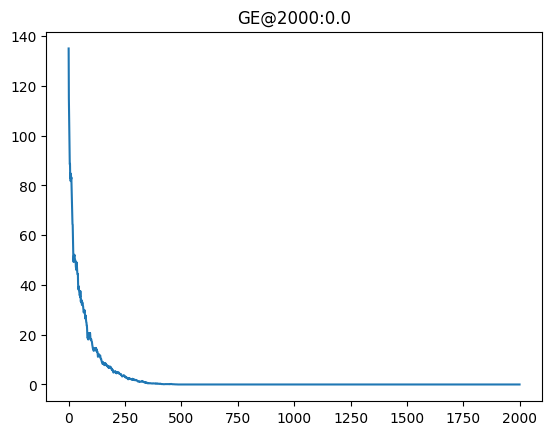

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ge)
ax.set_title(f'GE@{cfg.n_attack_traces}:{ge[-1]}')
fig.savefig(Path(cfg.save_path, f'{cfg.model.name}.png'), dpi=300)

Plot trained KAN

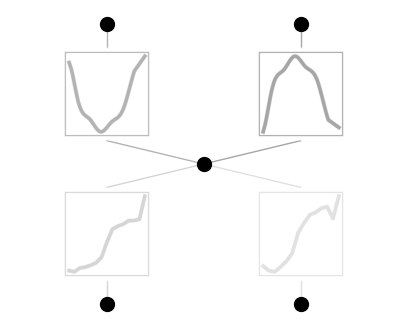

In [28]:
test_inputs = torch.tensor(
    np.array([test_dataset[v][0] for v in range(cfg.n_attack_traces)])).to(device)
_ = model(test_inputs)
model.plot(folder=cfg.save_path+'/attack')
plt.savefig(
    Path(cfg.save_path, f'{cfg.model.name}_attack.png'),
    dpi=300)
src.utils.plot_KAN(cfg, model, 'attack')

Set symbolic functions

In [29]:
model.fix_symbolic(0,0,0, 'x')
model.fix_symbolic(0,1,0, 'x')

r2 is 0.8969034552574158
r2 is not very high, please double check if you are choosing the correct symbolic function.
r2 is 0.9229035973548889


tensor(0.9229, device='cuda:0')

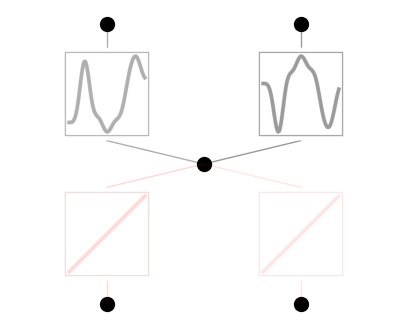

In [30]:
model(KANds['train_input'])
model.plot()

Fine-tuning

In [31]:
_ = model.train(
    KANds,
    **hydra.utils.instantiate(cfg.model.train_params)
    )

train loss: 8.36e-01 | test loss: 8.25e-01 | reg: 4.89e-01 : 100%|█| 5000/5000 [02:26<00:00, 34.05it


Evaluate

In [32]:
preds, labels, th = src.utils.make_prediction(
    model, test_dataloader, device,
    cfg.label_transforms.one_hot)

preds_class = np.argmax(preds, axis=1)
accuracy = np.mean(labels == preds_class)
print('Accuracy: ', accuracy)

Accuracy:  0.5624


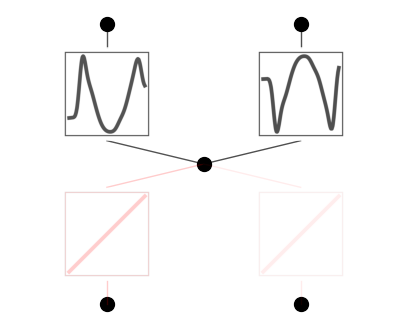

In [33]:
model(KANds['train_input'])
model.plot()

In [34]:
ge = src.sca_utils.calc_guessing_entropy(
    preds, label_hyposesis, correct_key,
    cfg.n_attack_traces, n_trial=cfg.n_trials)

Calculating GE [/trials]: 100%|██████████| 40/40 [00:01<00:00, 30.26it/s]


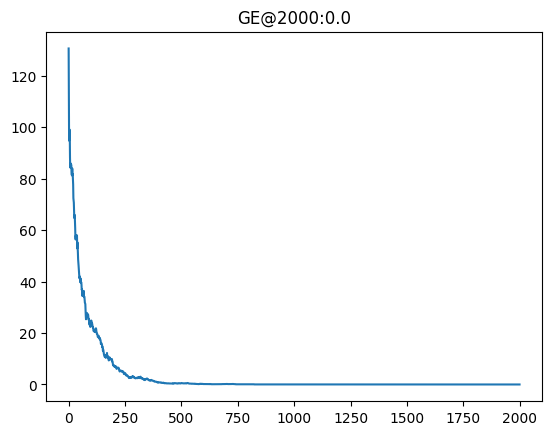

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ge)
ax.set_title(f'GE@{cfg.n_attack_traces}:{ge[-1]}')
fig.savefig(Path(cfg.save_path, f'{cfg.model.name}.png'), dpi=300)

Make symbolic formula

In [36]:
# formula, variables = model.symbolic_formula()
# with open(Path(cfg.save_path, 'symbolic_fomula.pkl'), mode='wb') as f:
#     pickle.dump((formula, variables), f)

make sure all activations need to be converted to symbolic formulas first!


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
# formula[1]